<a href="https://www.kaggle.com/code/rashidrk/tb-detection-with-yolo-12?scriptVersionId=232951408" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
!pip install ultralytics -q
from PIL import Image, ImageDraw
from pathlib import Path
import os
import xml.etree.ElementTree as ET
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml
import matplotlib.patches as patches
import random
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 41.4 MB/s eta 0:00:00


In [2]:
annotations_path = Path("/kaggle/input/tbx-11/TBX11K/annotations/xml")
images_path = Path("/kaggle/input/tbx-11/TBX11K/imgs")

annotations = os.listdir(annotations_path)
images = os.listdir(images_path)

annotations.sort()
images.sort()

In [3]:
def read_file_paths(file_path : str):
    with open(file_path, 'r') as f:
        all_files = f.readlines()
        return all_files


train_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_train.txt")
test_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")
val_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")

test_paths[:4]

['test/unknown_1.png\n',
 'test/unknown_2.png\n',
 'test/unknown_3.png\n',
 'test/unknown_4.png\n']

In [4]:
len(train_paths)

6888

In [5]:
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Basic file info
    filename = root.find('filename').text
    segmented = int(root.find('segmented').text)

    # Image size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = int(obj.find('truncated').text)
        difficult = int(obj.find('difficult').text)

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        annotations.append({
            'name': name,
            'pose': pose,
            'truncated': truncated,
            'difficult': difficult,
            'bbox': {
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            }
        })

    return {
        'filename': filename,
        'segmented': segmented,
        'size': {
            'width': width,
            'height': height
        },
        'objects': annotations
    }


In [6]:
parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

{'filename': 'tb0003',
 'segmented': 0,
 'size': {'width': 2840, 'height': 2827},
 'objects': [{'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 1446, 'ymin': 250, 'xmax': 2007, 'ymax': 1017}},
  {'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 618, 'ymin': 391, 'xmax': 1177, 'ymax': 1013}}]}

In [7]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [8]:
def plot_image_with_bboxes(image_path, annotation_data):
    # Load and resize the image to match annotation size
    image = Image.open(image_path)
    annotated_width = annotation_data['size']['width']
    annotated_height = annotation_data['size']['height']
    image = image.resize((annotated_width, annotated_height))

    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Assign unique colors to each class
    class_names = list(set(obj['name'] for obj in annotation_data['objects']))
    color_map = {cls: (random.random(), random.random(), random.random()) for cls in class_names}

    # Draw each bounding box
    for obj in annotation_data['objects']:
        bbox = obj['bbox']
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        box_width = xmax - xmin
        box_height = ymax - ymin

        label = obj['name']
        color = color_map[label]

        # Draw rectangle
        rect = patches.Rectangle(
            (xmin, ymin), box_width, box_height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

        # Add class label
        ax.text(xmin, ymin - 5, label, color=color, fontsize=10, weight='bold', backgroundcolor='white')

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
annotations[-1]

'tb1199.xml'

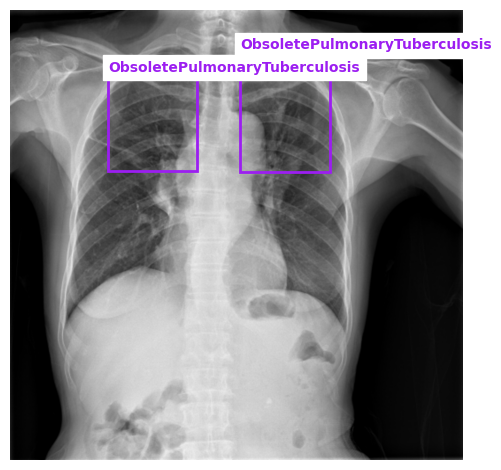

In [10]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0003.png", objects)

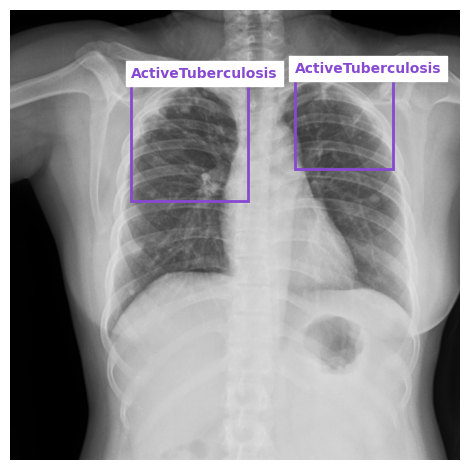

In [11]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0235.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0235.png", objects)

In [12]:
classes_set = set([])

for annon in annotations:
    objects = parse_xml(annotations_path / annon)
    objects = objects['objects']
    for obj in objects:
        classes_set.add(obj['name'])

In [13]:
classes_set

{'ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis'}

# prep data for training

In [14]:
class_map = {
    "ActiveTuberculosis" : 0,
    "ObsoletePulmonaryTuberculosis" : 1
}

In [15]:
def convert_to_yolo_format(xml_path, output_dir, class_map=class_map):
    """
    Converts XML annotations to YOLO format.

    Args:
        xml_path: Path to the XML annotation file.
        output_dir: Directory to save the YOLO annotation files.
        class_map: Dict mapping class names to YOLO class IDs, e.g. {"ActiveTuberculosis": 0, "HealedTuberculosis": 1}

    Returns:
        None: Saves YOLO annotation files to output_dir.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Image size
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)

    yolo_annotations = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        if name not in class_map:
            continue  # skip unknown classes

        class_id = class_map[name]

        # Bounding box
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Normalize for YOLO format
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        box_width = (xmax - xmin) / img_width
        box_height = (ymax - ymin) / img_height

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    # Save to .txt file in YOLO format
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / (xml_path.stem + ".txt")
    
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_annotations))


In [16]:
annotations = [annotations_path / annon for annon in annotations]
annotations[:10]

[PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0004.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0005.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0006.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0007.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0009.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0012.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0014.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0015.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0017.xml')]

In [17]:
train_data, val_data = train_test_split(annotations, random_state = 42, test_size = 0.2)

In [18]:
output_dir = Path("/kaggle/working/")

directories = ['train', 'val']
for data_dir in directories:
    images_output_dir = output_dir / f"{data_dir}/images"
    labels_output_dir = output_dir / f"{data_dir}/labels"

    os.makedirs(images_output_dir, exist_ok = True)
    os.makedirs(labels_output_dir, exist_ok = True)

In [19]:
directories_dict = {
    "train" : Path("/kaggle/working/train"),
    "val" : Path("/kaggle/working/val")
}

In [20]:
annotations[0].stem

'tb0003'

In [21]:
def move_image_to_dir(image_path, images_output_dir):
    image = Image.open(image_path)
    images_output_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    image.save(images_output_dir / Path(image_path).name)


def generate_yolo_dir(data_list : List, data_dir):
    images_output_dir = directories_dict[data_dir] / "images"
    labels_output_dir = directories_dict[data_dir] / "labels"
    
    for annon_path in tqdm(
        data_list, 
        total=len(data_list), 
        desc="Processing Images and Annotations"
    ):
        img_path = images_path / "tb" / f"{annon_path.stem}.png"
        move_image_to_dir(img_path, images_output_dir)
        convert_to_yolo_format(annon_path, labels_output_dir)

In [22]:
generate_yolo_dir(train_data, "train")

Processing Images and Annotations: 100%|██████████| 640/640 [00:52<00:00, 12.09it/s]


In [23]:
generate_yolo_dir(val_data, "val")

Processing Images and Annotations: 100%|██████████| 160/160 [00:13<00:00, 12.20it/s]


In [24]:
# display one of the files
with open("/kaggle/working/train/labels/tb0003.txt") as f:
    print(f.read())

1 0.607923 0.224089 0.197535 0.271312
1 0.316021 0.248320 0.196831 0.220021


In [25]:
num_classes = 2
names = ['ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis']

dict_file = {
    'train': str(directories_dict['train']),
    'val': str(directories_dict['val']),
    'nc': num_classes,
    'names': names,
    'augment': { # apply data augmentations
        'flipud': 0.0,  # Probability of vertical flip
        'fliplr': 0.5,  # Probability of horizontal flip
        'hsv_h': 0.015,  # HSV hue augmentation 
        'hsv_s': 0.7,  # HSV saturation augmentation
        'hsv_v': 0.4   # HSV value augmentation
    }
}

# Save to the data.yaml file
with open("/kaggle/working/data.yaml", 'w') as file:
    yaml.dump(dict_file, file, default_flow_style=False)

In [26]:
# display 
with open("/kaggle/working/data.yaml", "r") as f:
    print(f.read())

augment:
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
names:
- ActiveTuberculosis
- ObsoletePulmonaryTuberculosis
nc: 2
train: /kaggle/working/train
val: /kaggle/working/val



In [27]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
except Exception as e:
    print(e)
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rashidkisejjere0784. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
from ultralytics import YOLO

model = YOLO('yolo12m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 39.0M/39.0M [00:00<00:00, 404MB/s]


In [29]:
results = model.train(data="/kaggle/working/data.yaml",
                      epochs=80,
                      patience=40,
                      cos_lr = True,
                      seed = 42)

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/data.yaml, epochs=80, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 122MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2689536  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 274MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 640 images, 1 backgrounds, 0 corrupt: 100%|██████████| 640/640 [00:00<00:00, 1151.52it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/val/labels... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 860.31it/s]


val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0005), 129 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      12.2G      2.228      3.729      2.315         30        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      13.3G      2.159      2.799      2.254         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      13.3G       2.23      2.779      2.254         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      13.3G       2.13      2.652       2.21         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:02<00:00,  1.70it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        160        247   7.57e-05      0.013   3.87e-05   4.63e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      13.3G      2.158      2.669      2.235         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        160        247    0.00104     0.0285   0.000339   7.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      13.3G      2.115      2.572      2.202         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.104      0.123    0.00579    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      13.3G      2.044      2.515      2.139         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        160        247     0.0252      0.104     0.0145    0.00366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      13.3G      2.026      2.469      2.092         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        160        247     0.0919        0.3     0.0874     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      13.3G      2.022      2.478      2.113         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        160        247      0.312      0.261      0.183      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      13.3G      1.981      2.429      2.072         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.648      0.117      0.107     0.0282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      13.3G      1.971      2.384      2.052         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        160        247      0.659      0.228       0.18     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      13.3G      1.875      2.283      2.024         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        160        247       0.61      0.137     0.0791     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      13.3G      1.897      2.329       2.01         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        160        247      0.242     0.0796     0.0572     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      13.3G      1.888      2.296      1.995         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.736      0.198      0.225      0.074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      13.3G      1.861      2.253      1.974         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.714      0.249       0.25     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      13.3G      1.919      2.257      2.006         47        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.771      0.271      0.294      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      13.3G      1.934      2.275      2.038         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.706      0.241      0.239     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      13.3G      1.866      2.189      1.983         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.489      0.282      0.266     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      13.3G      1.867      2.205      1.945         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        160        247      0.672      0.223      0.196     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      13.3G      1.818      2.169      1.937         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.727      0.246      0.232     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      13.3G      1.852      2.119      1.948         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.689      0.205      0.203     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      13.3G      1.814       2.16      1.933         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.813      0.272      0.331      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      13.3G       1.82      2.119      1.932         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.689      0.288      0.256     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      13.3G      1.837      2.076      1.951         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.742      0.269      0.268     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      13.3G      1.797      2.077      1.919         49        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247       0.74      0.306        0.3      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      13.3G      1.773      2.082      1.898         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        160        247      0.694      0.246      0.224     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      13.3G      1.792      2.008      1.872         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.793      0.296      0.307      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      13.3G      1.803      2.085      1.907         38        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.759      0.277      0.293       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      13.3G      1.789       2.06      1.877         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.802      0.277      0.333      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      13.3G      1.774      2.038      1.917         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.797      0.303      0.331      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      13.3G       1.76      1.985      1.878         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.827      0.301      0.348      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      13.3G       1.81      1.951      1.896         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.806      0.339      0.372       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      13.3G      1.789       1.99      1.873         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.777      0.302      0.313      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      13.3G      1.761      1.982      1.879         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.783      0.298      0.332      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      13.3G      1.792      2.049      1.894         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.724      0.212      0.216     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      13.3G      1.715      1.998      1.856         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.796      0.306      0.353      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      13.3G      1.752      1.928      1.864         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.805      0.311      0.348      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      13.3G      1.731      1.965      1.851         28        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.83      0.316      0.344       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      13.3G      1.743      1.933       1.85         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.817      0.324      0.361      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      13.3G      1.725      1.925      1.833         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.852      0.347      0.389      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      13.3G      1.719       1.91       1.85         26        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.847      0.355      0.398      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      13.3G      1.727      1.904      1.824         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.844      0.324      0.386      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      13.3G      1.719      1.947      1.852         54        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        160        247       0.83      0.308       0.37      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      13.3G      1.732      1.908      1.875         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.826      0.324      0.387      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      13.3G        1.7      1.835      1.795         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.808      0.358      0.389      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      13.3G      1.694      1.915      1.836         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.821      0.345      0.398      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      13.3G       1.69      1.872      1.836         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247      0.315      0.433      0.374      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      13.3G      1.699      1.826      1.816         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.819      0.337      0.395      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      13.3G      1.654      1.774       1.79         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.835      0.355      0.397      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      13.3G      1.649       1.79      1.773         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.825      0.368        0.4      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      13.3G      1.668      1.791      1.796         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.831      0.365      0.404      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      13.3G      1.623      1.744      1.755         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.839      0.329      0.404      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      13.3G      1.621      1.713      1.749         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.275      0.469        0.4      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      13.3G      1.608      1.712      1.748         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.838      0.358      0.407      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      13.3G      1.628      1.752      1.768         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.834      0.342      0.422      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      13.3G      1.602       1.73      1.734         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.832      0.348      0.399      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      13.3G      1.647      1.797      1.774         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.845       0.36      0.408      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      13.3G      1.609      1.724       1.77         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.858       0.35      0.411      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      13.3G      1.588      1.697      1.739         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.834      0.354      0.413       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      13.3G      1.582      1.655      1.722         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.828      0.367      0.419      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      13.3G      1.611      1.707      1.753         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.296      0.527      0.416      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      13.3G      1.561      1.656      1.706         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.855      0.342      0.413      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      13.3G      1.568      1.676      1.718         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.857      0.354      0.432      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      13.3G      1.592      1.665      1.733         34        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.844      0.359      0.427        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      13.3G      1.601      1.632      1.725         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.837       0.36      0.451       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      13.3G      1.597      1.736      1.721         61        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.866      0.337      0.434      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      13.3G      1.568      1.644      1.741         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247       0.84      0.368      0.441      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      13.3G      1.542      1.639      1.711         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.843      0.367      0.429      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      13.3G       1.53       1.59      1.689         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.303      0.581      0.456      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      13.3G      1.562      1.637      1.718         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.853      0.381      0.458      0.217


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      13.3G      1.568      1.627      1.881         24        640: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.837      0.376      0.454      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      13.3G      1.551      1.556      1.868         25        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.329      0.506      0.445      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      13.3G      1.539      1.548      1.852         23        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.308      0.599      0.451      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      13.3G      1.526       1.54      1.845         21        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.301      0.594      0.455      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      13.3G       1.54      1.533      1.838         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.29      0.573      0.449      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      13.3G      1.508      1.516      1.819         20        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.289       0.57      0.452      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      13.3G      1.515      1.513      1.832         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.299      0.582      0.457      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      13.3G      1.535      1.506      1.872         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.301      0.624      0.465      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      13.3G      1.523      1.518      1.843         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.297      0.586      0.471      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      13.3G      1.522      1.522      1.831         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.298      0.622      0.465      0.225



80 epochs completed in 0.923 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,106,454 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


                   all        160        247      0.298      0.622      0.464      0.225
    ActiveTuberculosis        129        193      0.446      0.891      0.755      0.368
ObsoletePulmonaryTuberculosis         36         54      0.151      0.352      0.173     0.0818


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 15.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


In [30]:
results.results_dict

{'metrics/precision(B)': 0.2984974128185412,
 'metrics/recall(B)': 0.6215182540053006,
 'metrics/mAP50(B)': 0.4637347391794238,
 'metrics/mAP50-95(B)': 0.2250095385541501,
 'fitness': 0.24888205861667748}

# Validation

In [31]:
df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
75,76,3156.63,1.50811,1.51627,1.81921,0.28900,0.56962,0.45169,0.21665,1.68804,1.51242,2.02189,0.000033,0.000033,0.000033
76,77,3197.98,1.51507,1.51297,1.83200,0.29942,0.58189,0.45718,0.22273,1.68655,1.50748,2.01716,0.000027,0.000027,0.000027
77,78,3239.50,1.53523,1.50612,1.87194,0.30126,0.62422,0.46541,0.22343,1.70063,1.49575,2.02296,0.000022,0.000022,0.000022
78,79,3281.06,1.52284,1.51775,1.84339,0.29650,0.58600,0.47147,0.22449,1.70347,1.50369,2.02504,0.000019,0.000019,0.000019
79,80,3322.72,1.52157,1.52243,1.83082,0.29793,0.62152,0.46483,0.22532,1.70064,1.50550,2.02971,0.000017,0.000017,0.000017


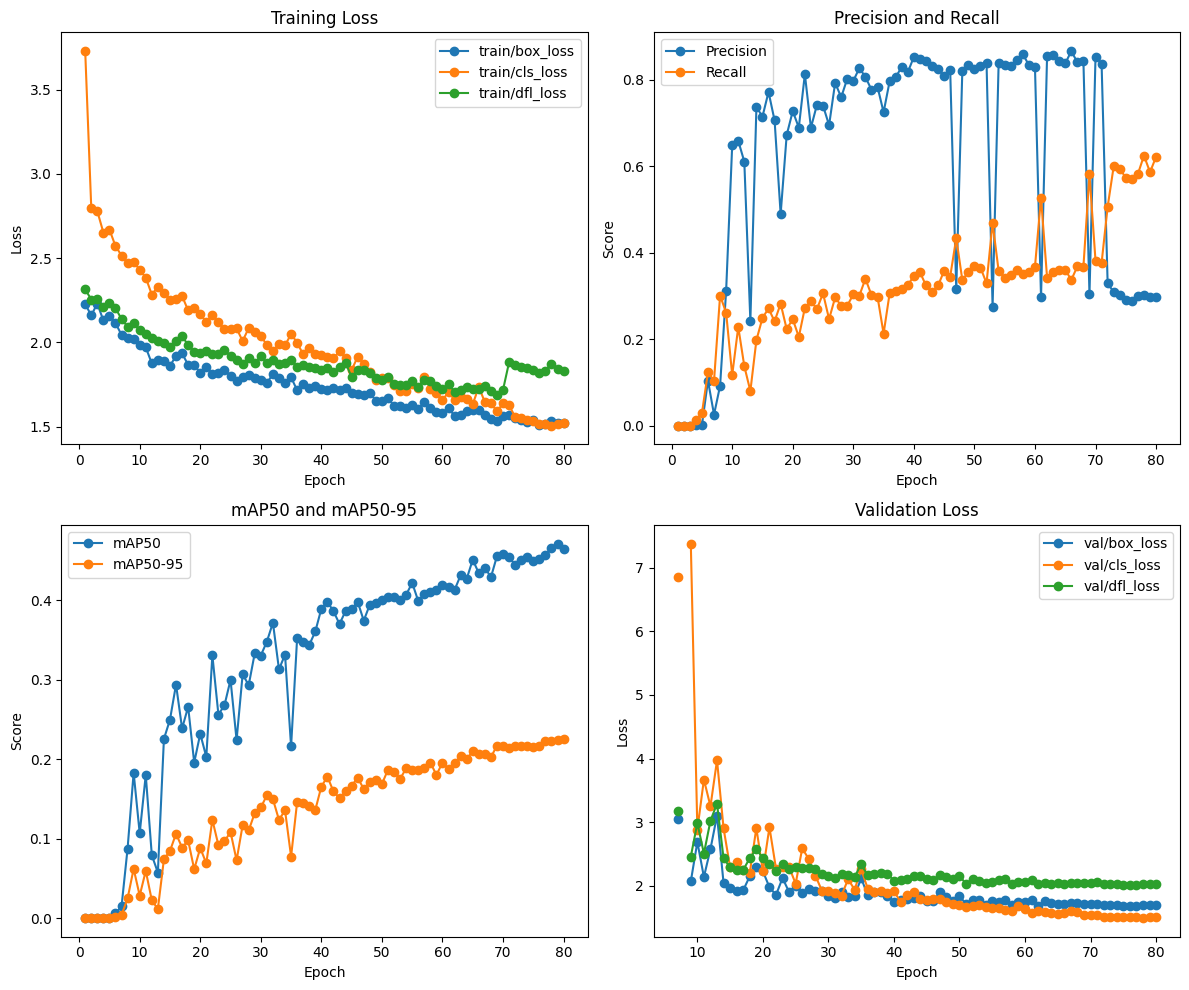

In [32]:
# Plotting selected metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting training loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='train/box_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss', marker='o')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting precision and recall
axes[0, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='o')
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='o')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()

# Plotting mAP50 and mAP50-95
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o')
axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o')
axes[1, 0].set_title('mAP50 and mAP50-95')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()

# Plotting validation loss
axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss', marker='o')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout and display
plt.tight_layout()

In [33]:
results = model.val()

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,106,454 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


                   all        160        247        0.3      0.622      0.465      0.225
    ActiveTuberculosis        129        193      0.448      0.891      0.755      0.368
ObsoletePulmonaryTuberculosis         36         54      0.151      0.352      0.175     0.0827


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /kaggle/working/train/images/tb0050.png: 640x640 2 ActiveTuberculosiss, 19.1ms
Speed: 3.3ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


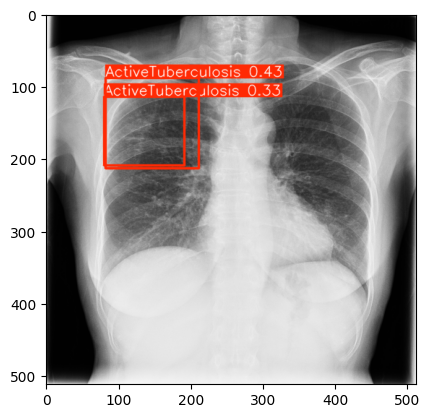

In [34]:
prediction = model.predict("/kaggle/working/train/images/tb0050.png")
plt.imshow(prediction[0].plot())

In [35]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (38.9 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 200.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 250.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 289.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.6s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 37.6s, saved as 'runs/detect/train/weights/best.onnx' (77.0

'runs/detect/train/weights/best.onnx'